# Time series clustering exercise

# Data

Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

The data is on the github repo. Each file is the economic census for 1 year. 
Download it programmatically and move it to PUIdata

 Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


In [1]:
import pandas as pd
import numpy as np
import geopandas as gp
import zipfile 
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pylab as pl
import scipy.cluster as scp
import os
from urllib.request import urlretrieve
import choroplethNYC as cp
from urllib.request import HTTPError

%matplotlib inline

In [2]:
years = ['94', '95', '96', '97', '98', '99', '00', '01', '02', 
         '03', '04', '05', '06', '07', '08', '09', '10', '11', 
         '12', '13', '14']

In [3]:
for i in years:
    if int(i) > 1 and int(i) < 20:
        urlretrieve('https://www2.census.gov/econ20'+i+'/CBP_CSV/zbp'+i+'totals.zip'
                       ,'zbp'+i+'totals.zip')
    else:
        urlretrieve('https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp'+i+'totals.zip'
                       ,'zbp'+i+'totals.zip')

In [4]:
datalist = []
for i in years:
    fname = "zbp" + i + "totals.zip"
    zf = zipfile.ZipFile(fname)
    datalist.append(pd.read_csv(zf.open(fname.replace('.zip','.txt'))))
    

In [5]:
for i in range(21):
    if 'zip' not in datalist[i].columns:
        datalist[i].rename(columns={"ZIP": "zip"},inplace = True)
    if 'est' not in datalist[i].columns:
        datalist[i].rename(columns={"EST": "est"},inplace = True)

In [6]:
for i in range(21):
    datalist[i].rename(columns={"est": years[i]},inplace = True)
    datalist[i] = datalist[i][['zip',years[i]]]

## You can use zipfile module in python to unzip the files
it should be installed in your system, but if it is not you can get the code with wget from here
https://github.com/python/cpython/blob/2.7/Lib/zipfile.py
remembering to use the raw link
(or you can use the usual shell commands)

# Data cleaning

you may need to clean your data: for some NYC zip codes there may be no info
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)


IMPORTANT: read the instructions below on pre-processing. Afte rthat:

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



## TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means
    in **a few** clusters (as discussed there is no real good, sound way to 
    decide what a good number is here. try a few options, keeping in mind 
    a few is more than a couple, but i recommand you stay within the 
    single digit numbers)
    
    3. plot the cluster centers (if you used K means those are the means of 
    the clusters). you can plot for example the cluster centers overlayed on 
    each time series (using the alpha channel to control the opacity in the 
    plot may be helpful here).
    
    4. Use another clustering algorithm (of your choice)
    
    5. overlay your data on a NYC map: you can use shapefiles for the 
    zip codes and different colors for different clusters
    
    6. Compare the results of the 2 algorithms
    
    7. attempt an interpretation. this is dangerous ground: clustering is 
    an exploratory tool so you do not want to jump to conclusions because 
    you see some clusters! but seeing structure in your data can inform 
    your next moves as an investigator. 
    

Note on preprocessing: the preparation of these data should include the "standardization" of the time seris. 
*Always when you apply a moachine learning model you should standardize the data or whiten it.*
These operations may be complicated preprocessing operation, they can for example invoke PCA, and they are aimed at removing covariance in the feature space.

The simplest version of whitening *standardizes each feature*" from every column (feature) you subtract the mean and you divide it by the standard deviation.

But the time series preprocessing is different if you want to use each time stamp as feature: because you want to maintain the coherence of the data, i.e. you **do not want** to treat each feature as an independent feature! the pattenrs in the time series are what you are clustering on (time series goes up and down, creating a pattern) and those patterns would be lost by whitening.

*So when you cluster or otherwise use a time series in a model, using each timestamp as a feature, you want to standardize the observations, not the features.* 

**From each row of your table (observation, in this case each zipcode) subtract the mean and you divide the row by the standard deviation.**

In [7]:
urlretrieve(' https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip',
                   'ZIP_CODE_040114.zip')
fname = "ZIP_CODE_040114.zip"
zf = zipfile.ZipFile(fname)
zf.extractall()

In [8]:
#nyczipsshp = gp.read_file(os.getenv("PUIDATA") + "/ZIP_CODE_040114.shp")
nyczipsshp = gp.read_file("ZIP_CODE_040114.shp")

print("ZIPCODES:",
      len(np.unique(nyczipsshp.ZIPCODE)), "POLYGONS:",
      len(nyczipsshp.ZIPCODE),
      "the difference is due to island with same zip as parts of land,",
      "but disjoint shapes")
nyczips = nyczipsshp.ZIPCODE.values.astype(int)
print("number of NYC zip codes:", len(nyczips))

ZIPCODES: 248 POLYGONS: 263 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 263


In [9]:
nyczipsshp.ZIPCODE = nyczipsshp.ZIPCODE.values.astype(int)

In [10]:
cbs = pd.DataFrame()
cbs['zip'] = datalist[0]['zip']
for i in range(21):
    cbs = pd.merge(cbs, datalist[i], left_on = 'zip', right_on= 'zip', how = 'outer')

In [11]:
allzip =nyczipsshp[['ZIPCODE']]

In [12]:
cbs = pd.merge(allzip, cbs, left_on = 'ZIPCODE', right_on= 'zip', how = 'left')

In [13]:
cbs.drop(columns='ZIPCODE',inplace = True)
cbs.set_index("zip", inplace=True)

In [14]:
cleancsb = cbs.dropna()

In [15]:
#cleaning all missing values
cleancsb.shape

(243, 21)

In [16]:
#then the standardization will look like:
vals = ((cleancsb.T - cleancsb.mean(1)) / cleancsb.std(1)).T

vals.mean(axis=1) should return 0 (or something very small) everywhere

vals.mean(axis=1).shape should be (260,)

vals.std(axis=1) should return 1 everywhere

vals.std(axis=1).shape

In [17]:
#cluster with kmeans
km = KMeans(n_clusters=5, random_state=444).fit(vals)

In [18]:
#each observation in the km object has a label: 
#that is the cluster assigned to that observation
km.labels_.shape

(243,)

In [19]:
kmresult = pd.DataFrame()
kmresult['zip'] = cleancsb.index
kmresult['km'] = km.labels_
vals['km'] = km.labels_

In [20]:
nyckm = nyczipsshp.merge(kmresult, left_on='ZIPCODE', right_on='zip', how='inner')

### The map of the clusters may look something like this

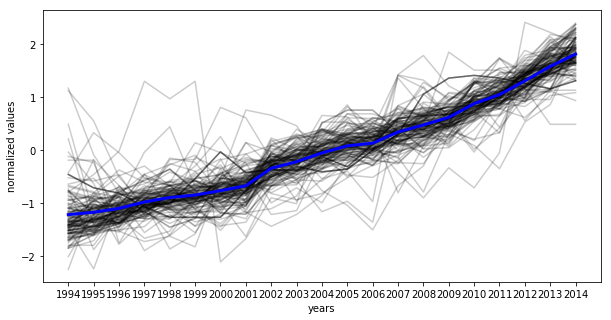

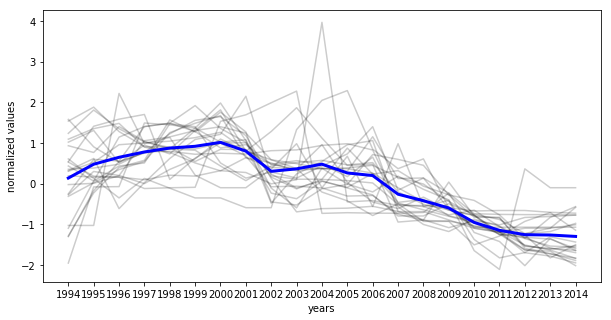

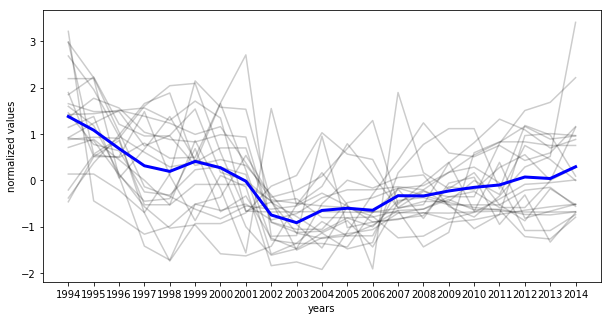

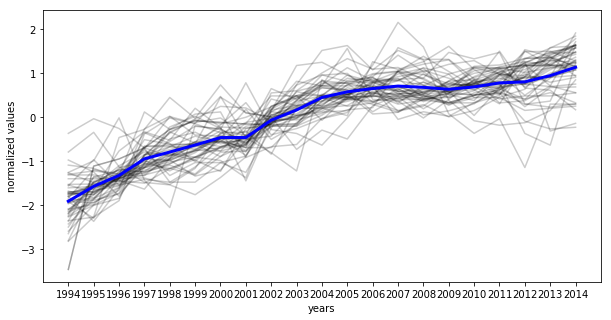

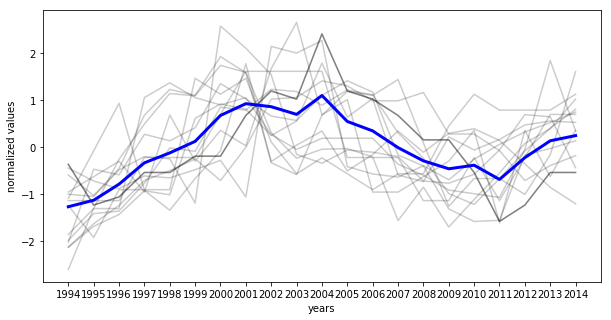

In [21]:
for x in range(5):
    pl.figure(figsize=(10,5))
    for y in range(len(vals[vals['km'] == x])):
        pl.plot(list(range(21)), vals[vals['km'] == x].iloc[y, 0:21], c = 'k', alpha = 0.2) 
    pl.plot(list(range(21)), list(vals[vals['km'] == x].mean(axis = 0))[0:-1], c = 'blue',lw = 3)
    pl.xticks(list(range(21)), range(1994,2015))
    pl.xlabel('years')
    pl.ylabel('normalized values')

Shown each cluster has significantly different trend

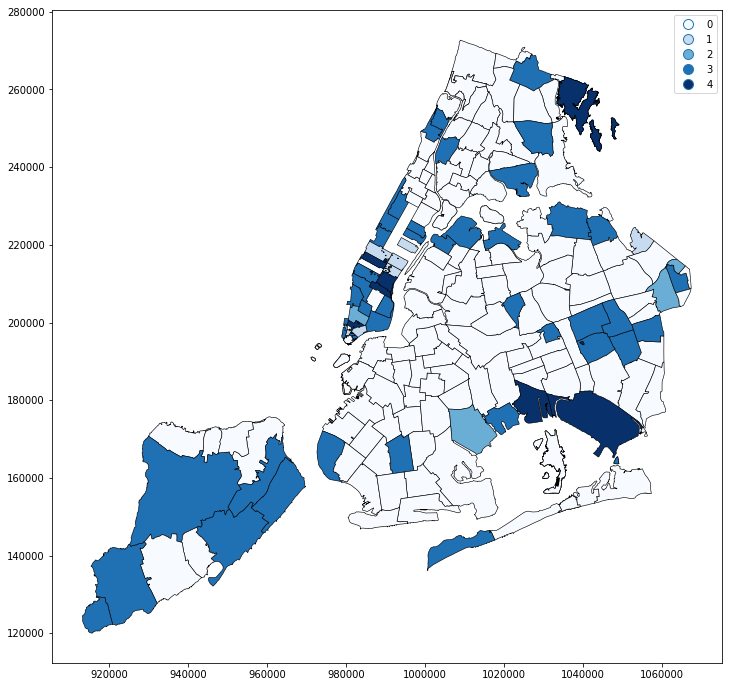

In [22]:
f, ax = pl.subplots(figsize=(12,12))
nyckm.plot(column='km', cmap="Blues",legend=True, edgecolor="black", 
           lw=0.6, categorical = True, ax=ax)

### Figure 3: 
cloropleth of  cluster centers for 5 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top.

### or maybe like this, depending on which algorithm you use, and how you proceed to preprocess your data and how you cluster it. There is no one correct answer, but general trends should be retrieved.

In [23]:
km = KMeans(n_clusters=7, random_state=444).fit(vals.iloc[:,0:21])

In [24]:
kmresult2 = pd.DataFrame()
kmresult2['zip'] = cleancsb.index
kmresult2['km'] = km.labels_
nyckm2 = nyczipsshp.merge(kmresult2, left_on='ZIPCODE', right_on='zip', how='inner')
vals['km1'] = km.labels_

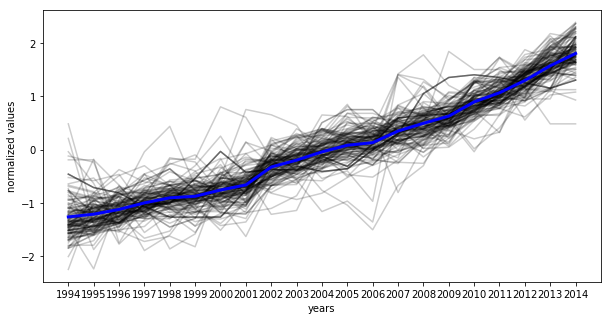

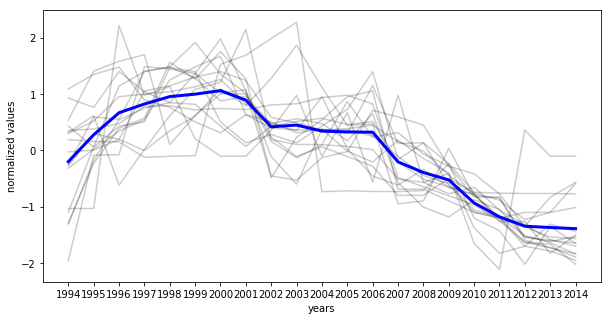

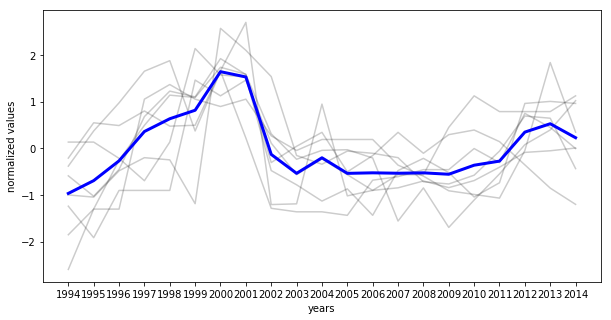

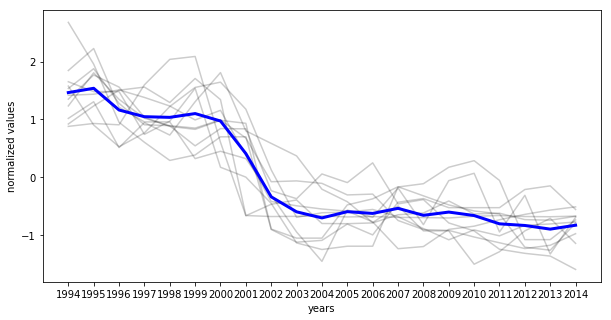

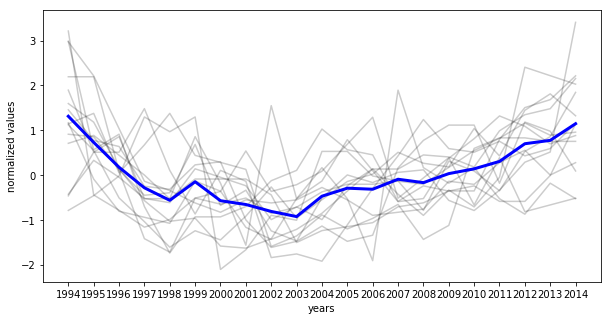

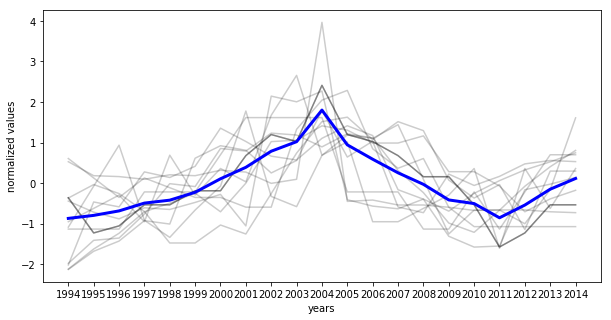

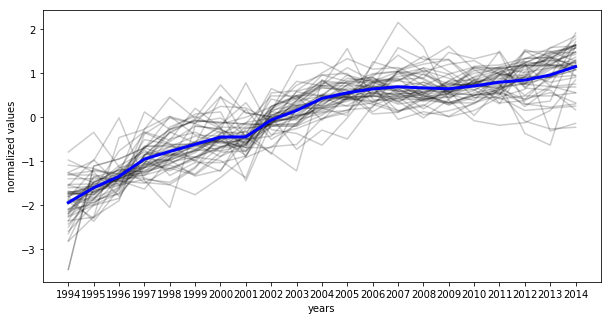

In [25]:
for x in range(7):
    pl.figure(figsize=(10,5))
    for y in range(len(vals[vals['km1'] == x])):
        pl.plot(list(range(21)), vals[vals['km1'] == x].iloc[y, 0:21], c = 'k', alpha = 0.2) 
    pl.plot(list(range(21)), list(vals[vals['km1'] == x].mean(axis = 0))[0:-2], c = 'blue',lw = 3)
    pl.xticks(list(range(21)), range(1994,2015))
    pl.xlabel('years')
    pl.ylabel('normalized values')

Shown each cluster has significantly different trend

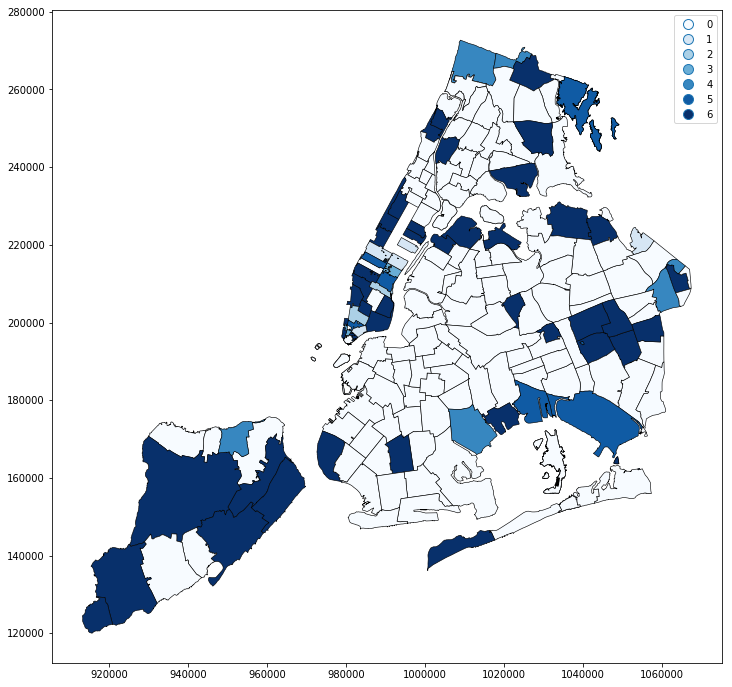

In [26]:
f, ax = pl.subplots(figsize=(12,12))
k = nyckm2.plot(column='km', cmap="Blues",legend=True, edgecolor="black", lw=0.6, ax=ax,categorical = True)

### Figure 9: 
As figures 3, 5, 7 for hierarchical agglomerative clustering in 7 clusters, with smoothed time series

# If you want to use agglomerative clustering

In [27]:
agc = AgglomerativeClustering(n_clusters=5, linkage='average').fit(vals)
labelsag = agc.labels_
centroidsag = np.zeros((5, vals.shape[1]))

### And if you use hierarchical clustering in scipy you can make a dandrogram it may look like this:

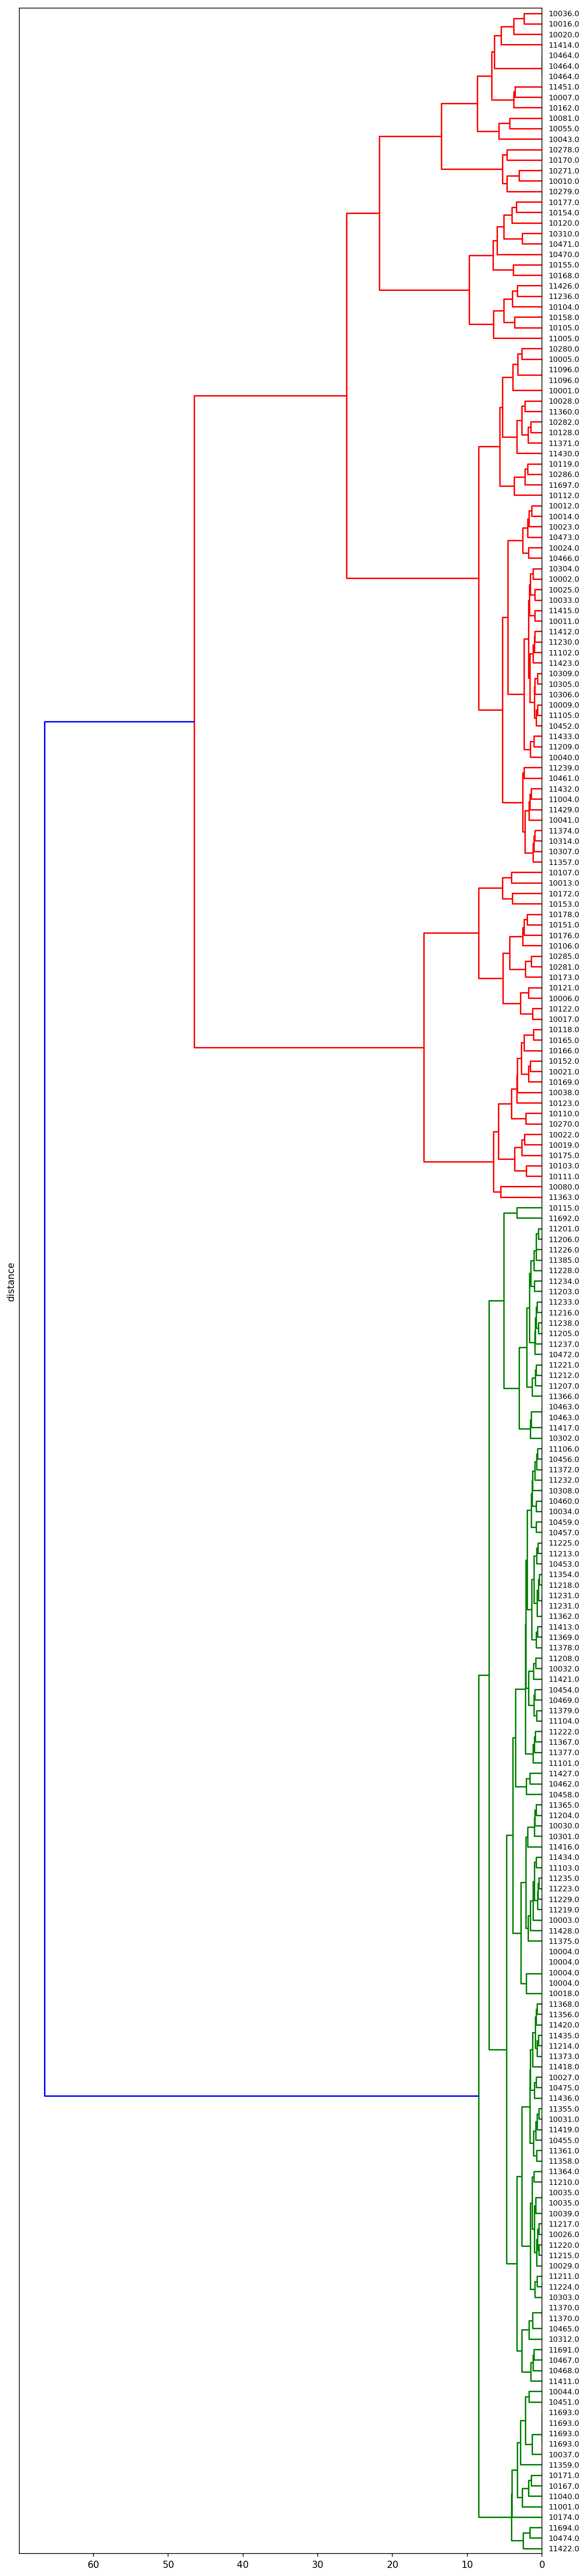

In [28]:
fig = pl.figure(figsize=(10,50), dpi=150)
pl.ylabel("distance")
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(vals, method='ward'), 
                               labels = vals.index,
                               leaf_font_size=8.,
                               orientation = "left")  # font size for the x axis labels)


In [29]:
agcresult = pd.DataFrame()
agcresult['zip'] = cleancsb.index
agcresult['agc'] = agc.labels_
nycagc = nyczipsshp.merge(agcresult, left_on='ZIPCODE', right_on='zip', how='inner')

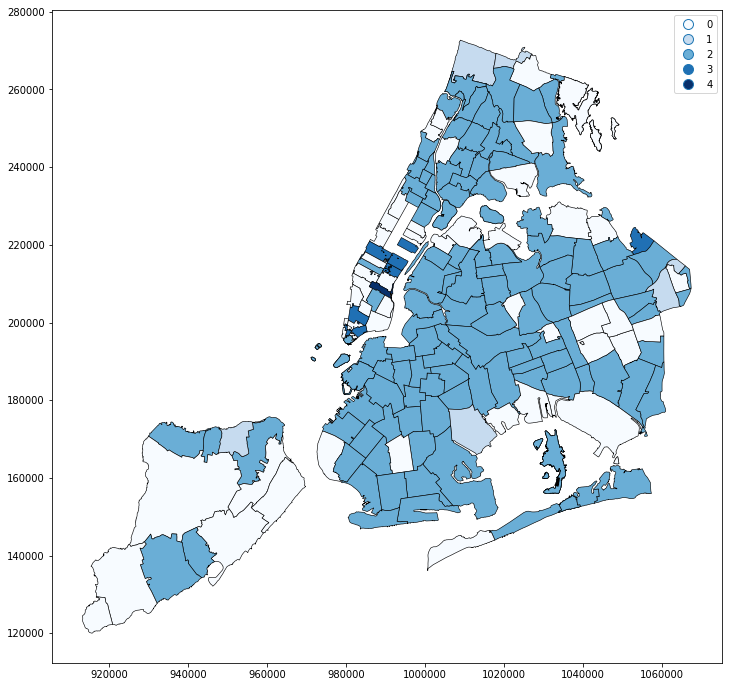

In [30]:
f, ax = pl.subplots(figsize=(12,12))
nycagc.plot(column='agc', cmap="Blues",legend=True, edgecolor="black", lw=0.6, ax=ax,categorical = True)

Although the two plots are different, agglomerative clustering and K-means clustering actually give similar results. Most places in NYC are assigned to a same clusters, which reflecting they are at the same level of number of business establishment, only a few places have significant more or less business establishment.